# 01 - Exploration: District Prediction

Load pre-computed embeddings and add district labels from county data.

**Goal:** Create a dataset of embeddings with district labels for training a classifier.

**Steps:**
1. Load pre-computed embeddings
2. Load eBird data for county information
3. Extract district labels from county names
4. Match embeddings to districts
5. Clean and save dataset

## Setup

In [22]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add backbone to path
project_root = Path.cwd().parent.parent.parent
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Current project: {Path.cwd().parent.name}")

Project root: c:\Users\Arnav\Documents\Python Scripts\bird embeddings
Current project: district_prediction


## 1. Load Pre-Computed Embeddings

In [23]:
# Load the embeddings created from train_vae_kerala.ipynb
embeddings_file = project_root / 'data' / 'processed' / 'kerala_embeddings_20251206_2156.npz'

print(f'Loading embeddings from: {embeddings_file}')
data = np.load(embeddings_file, allow_pickle=True)

embeddings = data['embeddings']
sampling_event_ids = data['sampling_event_ids']

print(f'\n✓ Loaded embeddings')
print(f'  Shape: {embeddings.shape}')
print(f'  Checklists: {len(embeddings):,}')
print(f'  Embedding dimension: {embeddings.shape[1]}')
print(f'\nStatistics:')
print(f'  Min: {embeddings.min():.4f}')
print(f'  Max: {embeddings.max():.4f}')
print(f'  Mean: {embeddings.mean():.4f}')
print(f'  Std: {embeddings.std():.4f}')

Loading embeddings from: c:\Users\Arnav\Documents\Python Scripts\bird embeddings\data\processed\kerala_embeddings_20251206_2156.npz

✓ Loaded embeddings
  Shape: (64895, 16)
  Checklists: 64,895
  Embedding dimension: 16

Statistics:
  Min: -4.2692
  Max: 5.0895
  Mean: 0.0046
  Std: 0.4742


## 2. Load eBird Data for COUNTY Information

In [24]:
from src.data import load_ebird_data

data_path = project_root / 'data' / 'raw' / 'ebd_IN-KL_smp_relSep-2025.txt'

print(f'Loading eBird data from: {data_path}')
print('This may take a few minutes...\n')

# Load all data (no nrows limit this time), why not lmao?
df = load_ebird_data(str(data_path), nrows=1000000)

print(f'\n✓ Loaded {len(df):,} observations')
print(f'  Unique checklists: {df["SAMPLING EVENT IDENTIFIER"].nunique():,}')
print(f'  Unique species: {df["COMMON NAME"].nunique():,}')

Loading eBird data from: c:\Users\Arnav\Documents\Python Scripts\bird embeddings\data\raw\ebd_IN-KL_smp_relSep-2025.txt
This may take a few minutes...

✓ Loaded eBird data from: ebd_IN-KL_smp_relSep-2025.txt
  Rows: 1,000,000
  Columns: 53
  (Limited to first 1,000,000 rows)

✓ Loaded 1,000,000 observations
  Unique checklists: 75,093
  Unique species: 680


In [25]:
# Filter to only checklists we have embeddings for
df_with_embeddings = df[df['SAMPLING EVENT IDENTIFIER'].isin(sampling_event_ids)].copy()

print(f'Filtered to checklists with embeddings:')
print(f'  Observations: {len(df_with_embeddings):,}')
print(f'  Unique checklists: {df_with_embeddings["SAMPLING EVENT IDENTIFIER"].nunique():,}')

Filtered to checklists with embeddings:
  Observations: 896,441
  Unique checklists: 64,895


## 3. Extract District Labels

In [26]:
# Kerala's 14 districts
KERALA_DISTRICTS = [
    'Thiruvananthapuram', 'Kollam', 'Pathanamthitta', 'Alappuzha',
    'Kottayam', 'Idukki', 'Ernakulam', 'Thrissur', 'Palakkad',
    'Malappuram', 'Kozhikode', 'Wayanad', 'Kannur', 'Kasaragod'
]

def extract_district(county_text):
    """Extract district from county string."""
    if pd.isna(county_text):
        return 'Unknown'
    
    county_lower = str(county_text).lower()
    
    # Check each district
    for district in KERALA_DISTRICTS:
        if district.lower() in county_lower:
            return district
    
    return 'Unknown'

# Apply to all localities
print('Extracting districts from county names...')
df_with_embeddings['district'] = df_with_embeddings['COUNTY'].apply(extract_district)

print('\nDistrict distribution in observations:')
print(df_with_embeddings['district'].value_counts())

Extracting districts from county names...

District distribution in observations:
district
Thrissur              176184
Alappuzha             169814
Ernakulam             145378
Palakkad              120208
Kannur                 72326
Idukki                 48171
Thiruvananthapuram     32004
Kottayam               27728
Malappuram             25053
Pathanamthitta         24331
Kozhikode              17569
Wayanad                16488
Kollam                 13588
Kasaragod               7469
Unknown                  130
Name: count, dtype: int64


In [27]:
df_with_embeddings.columns

Index(['GLOBAL UNIQUE IDENTIFIER', 'LAST EDITED DATE', 'TAXONOMIC ORDER',
       'CATEGORY', 'TAXON CONCEPT ID', 'COMMON NAME', 'SCIENTIFIC NAME',
       'SUBSPECIES COMMON NAME', 'SUBSPECIES SCIENTIFIC NAME', 'EXOTIC CODE',
       'OBSERVATION COUNT', 'BREEDING CODE', 'BREEDING CATEGORY',
       'BEHAVIOR CODE', 'AGE/SEX', 'COUNTRY', 'COUNTRY CODE', 'STATE',
       'STATE CODE', 'COUNTY', 'COUNTY CODE', 'IBA CODE', 'BCR CODE',
       'USFWS CODE', 'ATLAS BLOCK', 'LOCALITY', 'LOCALITY ID', 'LOCALITY TYPE',
       'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE',
       'TIME OBSERVATIONS STARTED', 'OBSERVER ID', 'OBSERVER ORCID ID',
       'SAMPLING EVENT IDENTIFIER', 'OBSERVATION TYPE', 'PROTOCOL NAME',
       'PROTOCOL CODE', 'PROJECT NAMES', 'PROJECT IDENTIFIERS',
       'DURATION MINUTES', 'EFFORT DISTANCE KM', 'EFFORT AREA HA',
       'NUMBER OBSERVERS', 'ALL SPECIES REPORTED', 'GROUP IDENTIFIER',
       'HAS MEDIA', 'APPROVED', 'REVIEWED', 'REASON', 'CHECKLIST COMMENTS',
       'SPECI

In [28]:
df_with_embeddings[df_with_embeddings['district'] == 'Unknown']['LOCALITY'].value_counts()

LOCALITY
Top Station View Point                                                   26
IN-Tamil Nadu-Uttamapalaiyam - 10.1194x77.2455 - 07-Mar-2016, 2:55 PM    25
Top Station- View Point Path                                             18
Kurangani- Top Station Trek                                              15
Top station Road                                                         12
pallur                                                                   11
Top Station                                                               9
East PALLOOR.                                                             9
Kaviyur                                                                   5
Name: count, dtype: int64

## 4. Create Checklist-Level Dataset

In [29]:
# Aggregate to checklist level (one row per checklist)
# Each checklist has one location/district
checklist_df = df_with_embeddings.groupby('SAMPLING EVENT IDENTIFIER').agg({
    'district': 'first',
    'COUNTY': 'first',
    'OBSERVATION DATE': 'first',
    'LATITUDE': 'first',
    'LONGITUDE': 'first'
}).reset_index()

print(f'Checklist-level data:')
print(f'  Unique checklists: {len(checklist_df):,}')
print(f'  Districts represented: {checklist_df["district"].nunique()}')
print(f'\nDistrict distribution in checklists:')
print(checklist_df['district'].value_counts())

Checklist-level data:
  Unique checklists: 64,895
  Districts represented: 15

District distribution in checklists:
district
Thrissur              14850
Alappuzha             11721
Ernakulam             11458
Palakkad               6968
Kannur                 4866
Idukki                 2720
Pathanamthitta         2225
Thiruvananthapuram     2043
Kottayam               1995
Kozhikode              1643
Malappuram             1623
Wayanad                1093
Kollam                 1023
Kasaragod               656
Unknown                  11
Name: count, dtype: int64


## 5. Match Embeddings to Districts

In [30]:
# Create mapping from sampling ID to embedding index
id_to_idx = {sid: i for i, sid in enumerate(sampling_event_ids)}

# Get embedding index for each checklist
checklist_df['embedding_idx'] = checklist_df['SAMPLING EVENT IDENTIFIER'].map(id_to_idx)

# Remove any that didn't match (shouldn't happen)
before = len(checklist_df)
checklist_df = checklist_df.dropna(subset=['embedding_idx'])
checklist_df['embedding_idx'] = checklist_df['embedding_idx'].astype(int)
after = len(checklist_df)

print(f'Matched embeddings to checklists:')
print(f'  Before: {before:,}')
print(f'  After: {after:,}')
print(f'  Dropped: {before - after}')

Matched embeddings to checklists:
  Before: 64,895
  After: 64,895
  Dropped: 0


In [31]:
# Extract corresponding embeddings and labels
X = embeddings[checklist_df['embedding_idx'].values]
y = checklist_df['district'].values

print(f'Dataset created:')
print(f'  Embeddings shape: {X.shape}')
print(f'  Labels: {len(y):,}')
print(f'\nLabel distribution:')
for district, count in pd.Series(y).value_counts().items():
    print(f'  {district:20s}: {count:5,} ({count/len(y)*100:5.2f}%)')

Dataset created:
  Embeddings shape: (64895, 16)
  Labels: 64,895

Label distribution:
  Thrissur            : 14,850 (22.88%)
  Alappuzha           : 11,721 (18.06%)
  Ernakulam           : 11,458 (17.66%)
  Palakkad            : 6,968 (10.74%)
  Kannur              : 4,866 ( 7.50%)
  Idukki              : 2,720 ( 4.19%)
  Pathanamthitta      : 2,225 ( 3.43%)
  Thiruvananthapuram  : 2,043 ( 3.15%)
  Kottayam            : 1,995 ( 3.07%)
  Kozhikode           : 1,643 ( 2.53%)
  Malappuram          : 1,623 ( 2.50%)
  Wayanad             : 1,093 ( 1.68%)
  Kollam              : 1,023 ( 1.58%)
  Kasaragod           :   656 ( 1.01%)
  Unknown             :    11 ( 0.02%)


## 6. Clean Data

In [32]:
# Remove 'Unknown' district
mask = y != 'Unknown'
X_clean = X[mask]
y_clean = y[mask]
checklist_df_clean = checklist_df[mask].reset_index(drop=True)

print(f'After removing "Unknown" district:')
print(f'  Samples: {len(X_clean):,} (removed {(~mask).sum():,})')
print(f'  Districts: {len(np.unique(y_clean))}')
print(f'\nFinal district distribution:')
for district, count in pd.Series(y_clean).value_counts().items():
    print(f'  {district:20s}: {count:5,} ({count/len(y_clean)*100:5.2f}%)')

After removing "Unknown" district:
  Samples: 64,884 (removed 11)
  Districts: 14

Final district distribution:
  Thrissur            : 14,850 (22.89%)
  Alappuzha           : 11,721 (18.06%)
  Ernakulam           : 11,458 (17.66%)
  Palakkad            : 6,968 (10.74%)
  Kannur              : 4,866 ( 7.50%)
  Idukki              : 2,720 ( 4.19%)
  Pathanamthitta      : 2,225 ( 3.43%)
  Thiruvananthapuram  : 2,043 ( 3.15%)
  Kottayam            : 1,995 ( 3.07%)
  Kozhikode           : 1,643 ( 2.53%)
  Malappuram          : 1,623 ( 2.50%)
  Wayanad             : 1,093 ( 1.68%)
  Kollam              : 1,023 ( 1.58%)
  Kasaragod           :   656 ( 1.01%)


## 7. Visualize Distribution

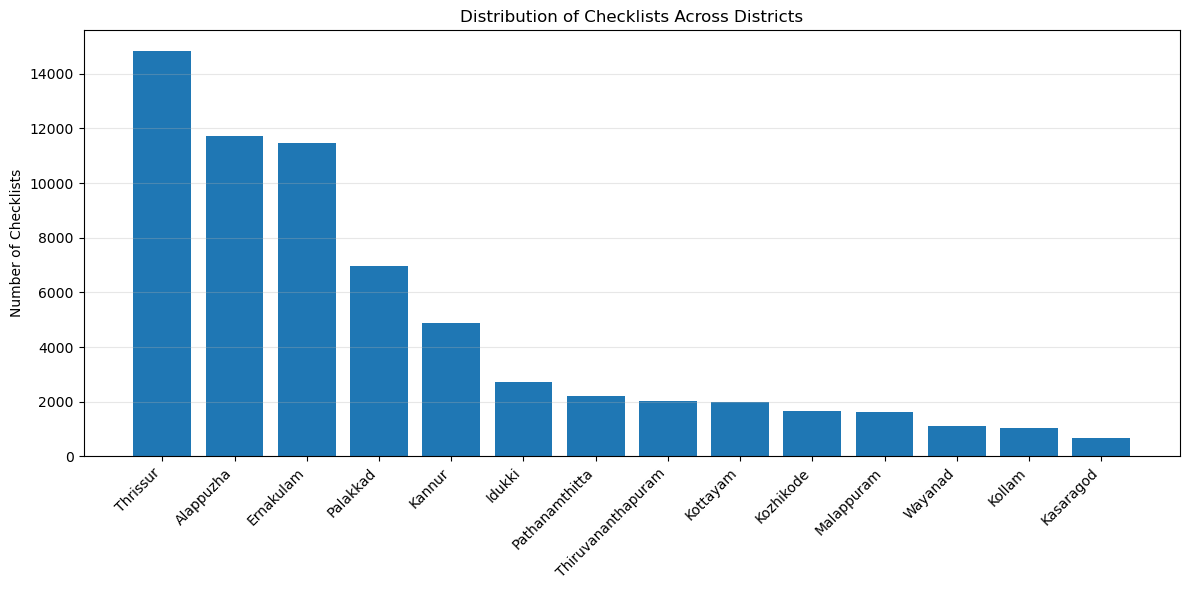


Min samples: 656 (Kasaragod)
Max samples: 14,850 (Thrissur)
Mean samples: 4634.6


In [33]:
# Bar plot of district distribution
district_counts = pd.Series(y_clean).value_counts()

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(district_counts)), district_counts.values)
plt.xticks(range(len(district_counts)), district_counts.index, rotation=45, ha='right')
plt.ylabel('Number of Checklists')
plt.title('Distribution of Checklists Across Districts')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f'\nMin samples: {district_counts.min():,} ({district_counts.idxmin()})')
print(f'Max samples: {district_counts.max():,} ({district_counts.idxmax()})')
print(f'Mean samples: {district_counts.mean():.1f}')

## 8. Save Dataset

In [34]:
# Save processed data for analysis
save_path = Path('../data/processed/embeddings_with_districts.npz')
save_path.parent.mkdir(parents=True, exist_ok=True)

np.savez_compressed(
    save_path,
    embeddings=X_clean,
    districts=y_clean,
    sampling_event_ids=checklist_df_clean['SAMPLING EVENT IDENTIFIER'].values,
    county=checklist_df_clean['COUNTY'].values,
    observation_date=checklist_df_clean['OBSERVATION DATE'].values,
    latitude=checklist_df_clean['LATITUDE'].values,
    longitude=checklist_df_clean['LONGITUDE'].values
)

file_size = save_path.stat().st_size / 1024 / 1024

print(f'✓ Saved dataset to: {save_path}')
print(f'  File size: {file_size:.2f} MB')
print(f'  Samples: {len(X_clean):,}')
print(f'  Features: {X_clean.shape[1]}')
print(f'  Districts: {len(np.unique(y_clean))}')

✓ Saved dataset to: ..\data\processed\embeddings_with_districts.npz
  File size: 3.43 MB
  Samples: 64,884
  Features: 16
  Districts: 14


## Summary

In [35]:
print('='*60)
print('EXPLORATION COMPLETE')
print('='*60)
print(f'\n📊 Dataset Statistics:')
print(f'   Total samples: {len(X_clean):,}')
print(f'   Embedding dimension: {X_clean.shape[1]}')
print(f'   Number of districts: {len(np.unique(y_clean))}')
print(f'\n🎯 District Coverage:')
for district in sorted(np.unique(y_clean)):
    count = (y_clean == district).sum()
    pct = count / len(y_clean) * 100
    print(f'   {district:20s}: {count:5,} ({pct:5.2f}%)')
print(f'\n💾 Output:')
print(f'   File: {save_path.name}')
print(f'   Location: data/processed/')
print(f'\n✨ Ready for classifier training!')
print('   Next: Run 02_analysis.ipynb')
print('='*60)

EXPLORATION COMPLETE

📊 Dataset Statistics:
   Total samples: 64,884
   Embedding dimension: 16
   Number of districts: 14

🎯 District Coverage:
   Alappuzha           : 11,721 (18.06%)
   Ernakulam           : 11,458 (17.66%)
   Idukki              : 2,720 ( 4.19%)
   Kannur              : 4,866 ( 7.50%)
   Kasaragod           :   656 ( 1.01%)
   Kollam              : 1,023 ( 1.58%)
   Kottayam            : 1,995 ( 3.07%)
   Kozhikode           : 1,643 ( 2.53%)
   Malappuram          : 1,623 ( 2.50%)
   Palakkad            : 6,968 (10.74%)
   Pathanamthitta      : 2,225 ( 3.43%)
   Thiruvananthapuram  : 2,043 ( 3.15%)
   Thrissur            : 14,850 (22.89%)
   Wayanad             : 1,093 ( 1.68%)

💾 Output:
   File: embeddings_with_districts.npz
   Location: data/processed/

✨ Ready for classifier training!
   Next: Run 02_analysis.ipynb
